In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os

def drop_outlier(array, count, bins):
    index = []
    range_ = np.arange(1, count, bins)
    for i in range_[:-1]:
        array_lim = array[i:i+bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max, th_min = mean + sigma*2, mean - sigma*2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)

# Define battery paths directly
Battery_paths = {
    'CS2_35': r"D:\CS2_35",
    'CS2_36': r"D:\CS2_36", 
    'CS2_37': r"D:\CS2_37",
    'CS2_38': r"D:\CS2_38"
}

Battery = {}

for name, path in Battery_paths.items():
    print(f'\nProcessing dataset {name} from {path}...')
    
    # Get all Excel files in the directory
    files = glob.glob(os.path.join(path, '*.xlsx'))
    if not files:
        print(f'No Excel files found in {path}, skipping...')
        continue
    
    print(f'Found {len(files)} files')
    
    # Read and sort files by date
    file_info = []
    for file in files:
        try:
            df = pd.read_excel(file, sheet_name=1)
            date = df['Date_Time'][0]
            file_info.append((date, file))
            print(f'Successfully loaded {file}')
        except Exception as e:
            print(f'Error loading {file}: {str(e)}')
            continue
    
    if not file_info:
        print(f'No valid files found for {name}, skipping...')
        continue
    
    # Sort files by date
    file_info.sort()
    sorted_files = [f[1] for f in file_info]
    
    # Process each file
    count = 0
    discharge_capacities = []
    health_indicator = []
    internal_resistance = []
    CCCT = []
    CVCT = []
    
    for file in sorted_files:
        print(f'Processing file: {file}')
        try:
            df = pd.read_excel(file, sheet_name=1)
            cycles = list(set(df['Cycle_Index']))
            print(f'Found {len(cycles)} cycles in file')
            
            for c in cycles:
                df_lim = df[df['Cycle_Index'] == c]
                
                # Discharging data - must exist
                df_d = df_lim[df_lim['Step_Index'] == 7]
                if len(df_d) == 0:
                    continue
                    
                # Charging data (CC and CV)
                df_cc = df_lim[df_lim['Step_Index'] == 2]
                df_cv = df_lim[df_lim['Step_Index'] == 4]
                
                # Discharge calculations
                d_v = df_d['Voltage(V)'].values
                d_c = df_d['Current(A)'].values
                d_t = df_d['Test_Time(s)'].values
                d_im = df_d['Internal_Resistance(Ohm)'].values
                
                time_diff = np.diff(d_t)
                discharge_capacity = time_diff * d_c[1:] / 3600
                discharge_capacity = np.cumsum(discharge_capacity)
                discharge_capacities.append(-1 * discharge_capacity[-1])
                
                # Health indicator calculation
                dec = np.abs(d_v[1:] - 3.8)
                start = discharge_capacity[np.argmin(dec)]
                dec = np.abs(d_v[1:] - 3.4)
                end = discharge_capacity[np.argmin(dec)]
                health_indicator.append(-1 * (end - start))
                
                internal_resistance.append(np.mean(d_im))
                
                # CC and CV times (may be empty)
                if len(df_cc) > 0:
                    CCCT.append(np.max(df_cc['Test_Time(s)']) - np.min(df_cc['Test_Time(s)']))
                else:
                    CCCT.append(np.nan)
                
                if len(df_cv) > 0:
                    CVCT.append(np.max(df_cv['Test_Time(s)']) - np.min(df_cv['Test_Time(s)']))
                else:
                    CVCT.append(np.nan)
                
                count += 1
                
        except Exception as e:
            print(f'Error processing file {file}: {str(e)}')
            continue
    
    print(f'Total cycles processed for {name}: {count}')
    
    if count == 0:
        print(f'No valid cycles found for {name}, skipping...')
        continue
        
    # Convert to numpy arrays
    discharge_capacities = np.array(discharge_capacities)
    health_indicator = np.array(health_indicator)
    internal_resistance = np.array(internal_resistance)
    CCCT = np.array(CCCT)
    CVCT = np.array(CVCT)
    
    # Remove outliers only from capacity data
    if len(discharge_capacities) > 0:
        idx = drop_outlier(discharge_capacities, count, 40)
    else:
        idx = np.array([])
    
    # Create DataFrame - ensure we only use indices that exist in all arrays
    if len(idx) > 0:
        # Find the minimum length among all arrays
        min_length = min(len(discharge_capacities), len(health_indicator), 
                       len(internal_resistance), len(CCCT), len(CVCT))
        
        # Filter idx to only include indices within bounds
        idx = idx[idx < min_length]
        
        df_result = pd.DataFrame({
            'cycle': np.arange(1, len(idx)+1),
            'capacity': discharge_capacities[idx],
            'SoH': health_indicator[idx],
            'resistance': internal_resistance[idx],
            'CCCT': CCCT[idx],
            'CVCT': CVCT[idx]
        })
        Battery[name] = df_result
        print(f"Battery['{name}'] DataFrame shape: {df_result.shape}")
    else:
        print(f"No valid data after outlier removal for {name}")

# Save the processed data
output_path = r"D:\CALCE_processed.npy"
np.save(output_path, Battery)
print(f"\nData successfully saved to {output_path}")

# Plotting
if Battery:
    fig, ax = plt.subplots(1, figsize=(12, 8))
    colors = ['b', 'g', 'r', 'c']
    markers = ['o', 's', '^', 'D']
    
    for i, (name, data) in enumerate(Battery.items()):
        ax.plot(data['cycle'], data['capacity'], 
                f'{colors[i]}:', 
                marker=markers[i], markevery=50,
                label=f'Battery {name}')
    
    ax.set(xlabel='Discharge cycles', 
           ylabel='Capacity (Ah)', 
           title='Capacity Degradation at 1°C')
    ax.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No battery data available for plotting")


Processing dataset CS2_35 from D:\CS2_35...
Found 25 files
Successfully loaded D:\CS2_35\CS2_35_10_15_10.xlsx
Successfully loaded D:\CS2_35\CS2_35_10_22_10.xlsx
Successfully loaded D:\CS2_35\CS2_35_10_29_10.xlsx
Successfully loaded D:\CS2_35\CS2_35_11_01_10.xlsx
Successfully loaded D:\CS2_35\CS2_35_11_08_10.xlsx
Successfully loaded D:\CS2_35\CS2_35_11_23_10.xlsx
Successfully loaded D:\CS2_35\CS2_35_11_24_10.xlsx
Successfully loaded D:\CS2_35\CS2_35_12_06_10.xlsx
Successfully loaded D:\CS2_35\CS2_35_12_13_10.xlsx
Successfully loaded D:\CS2_35\CS2_35_12_20_10.xlsx
Successfully loaded D:\CS2_35\CS2_35_12_23_10.xlsx
Successfully loaded D:\CS2_35\CS2_35_1_10_11.xlsx
Successfully loaded D:\CS2_35\CS2_35_1_18_11.xlsx
Successfully loaded D:\CS2_35\CS2_35_1_24_11.xlsx
Successfully loaded D:\CS2_35\CS2_35_1_28_11.xlsx
Successfully loaded D:\CS2_35\CS2_35_2_10_11.xlsx
Successfully loaded D:\CS2_35\CS2_35_2_4_11.xlsx
Successfully loaded D:\CS2_35\CS2_35_8_17_10.xlsx
Successfully loaded D:\CS2_35\

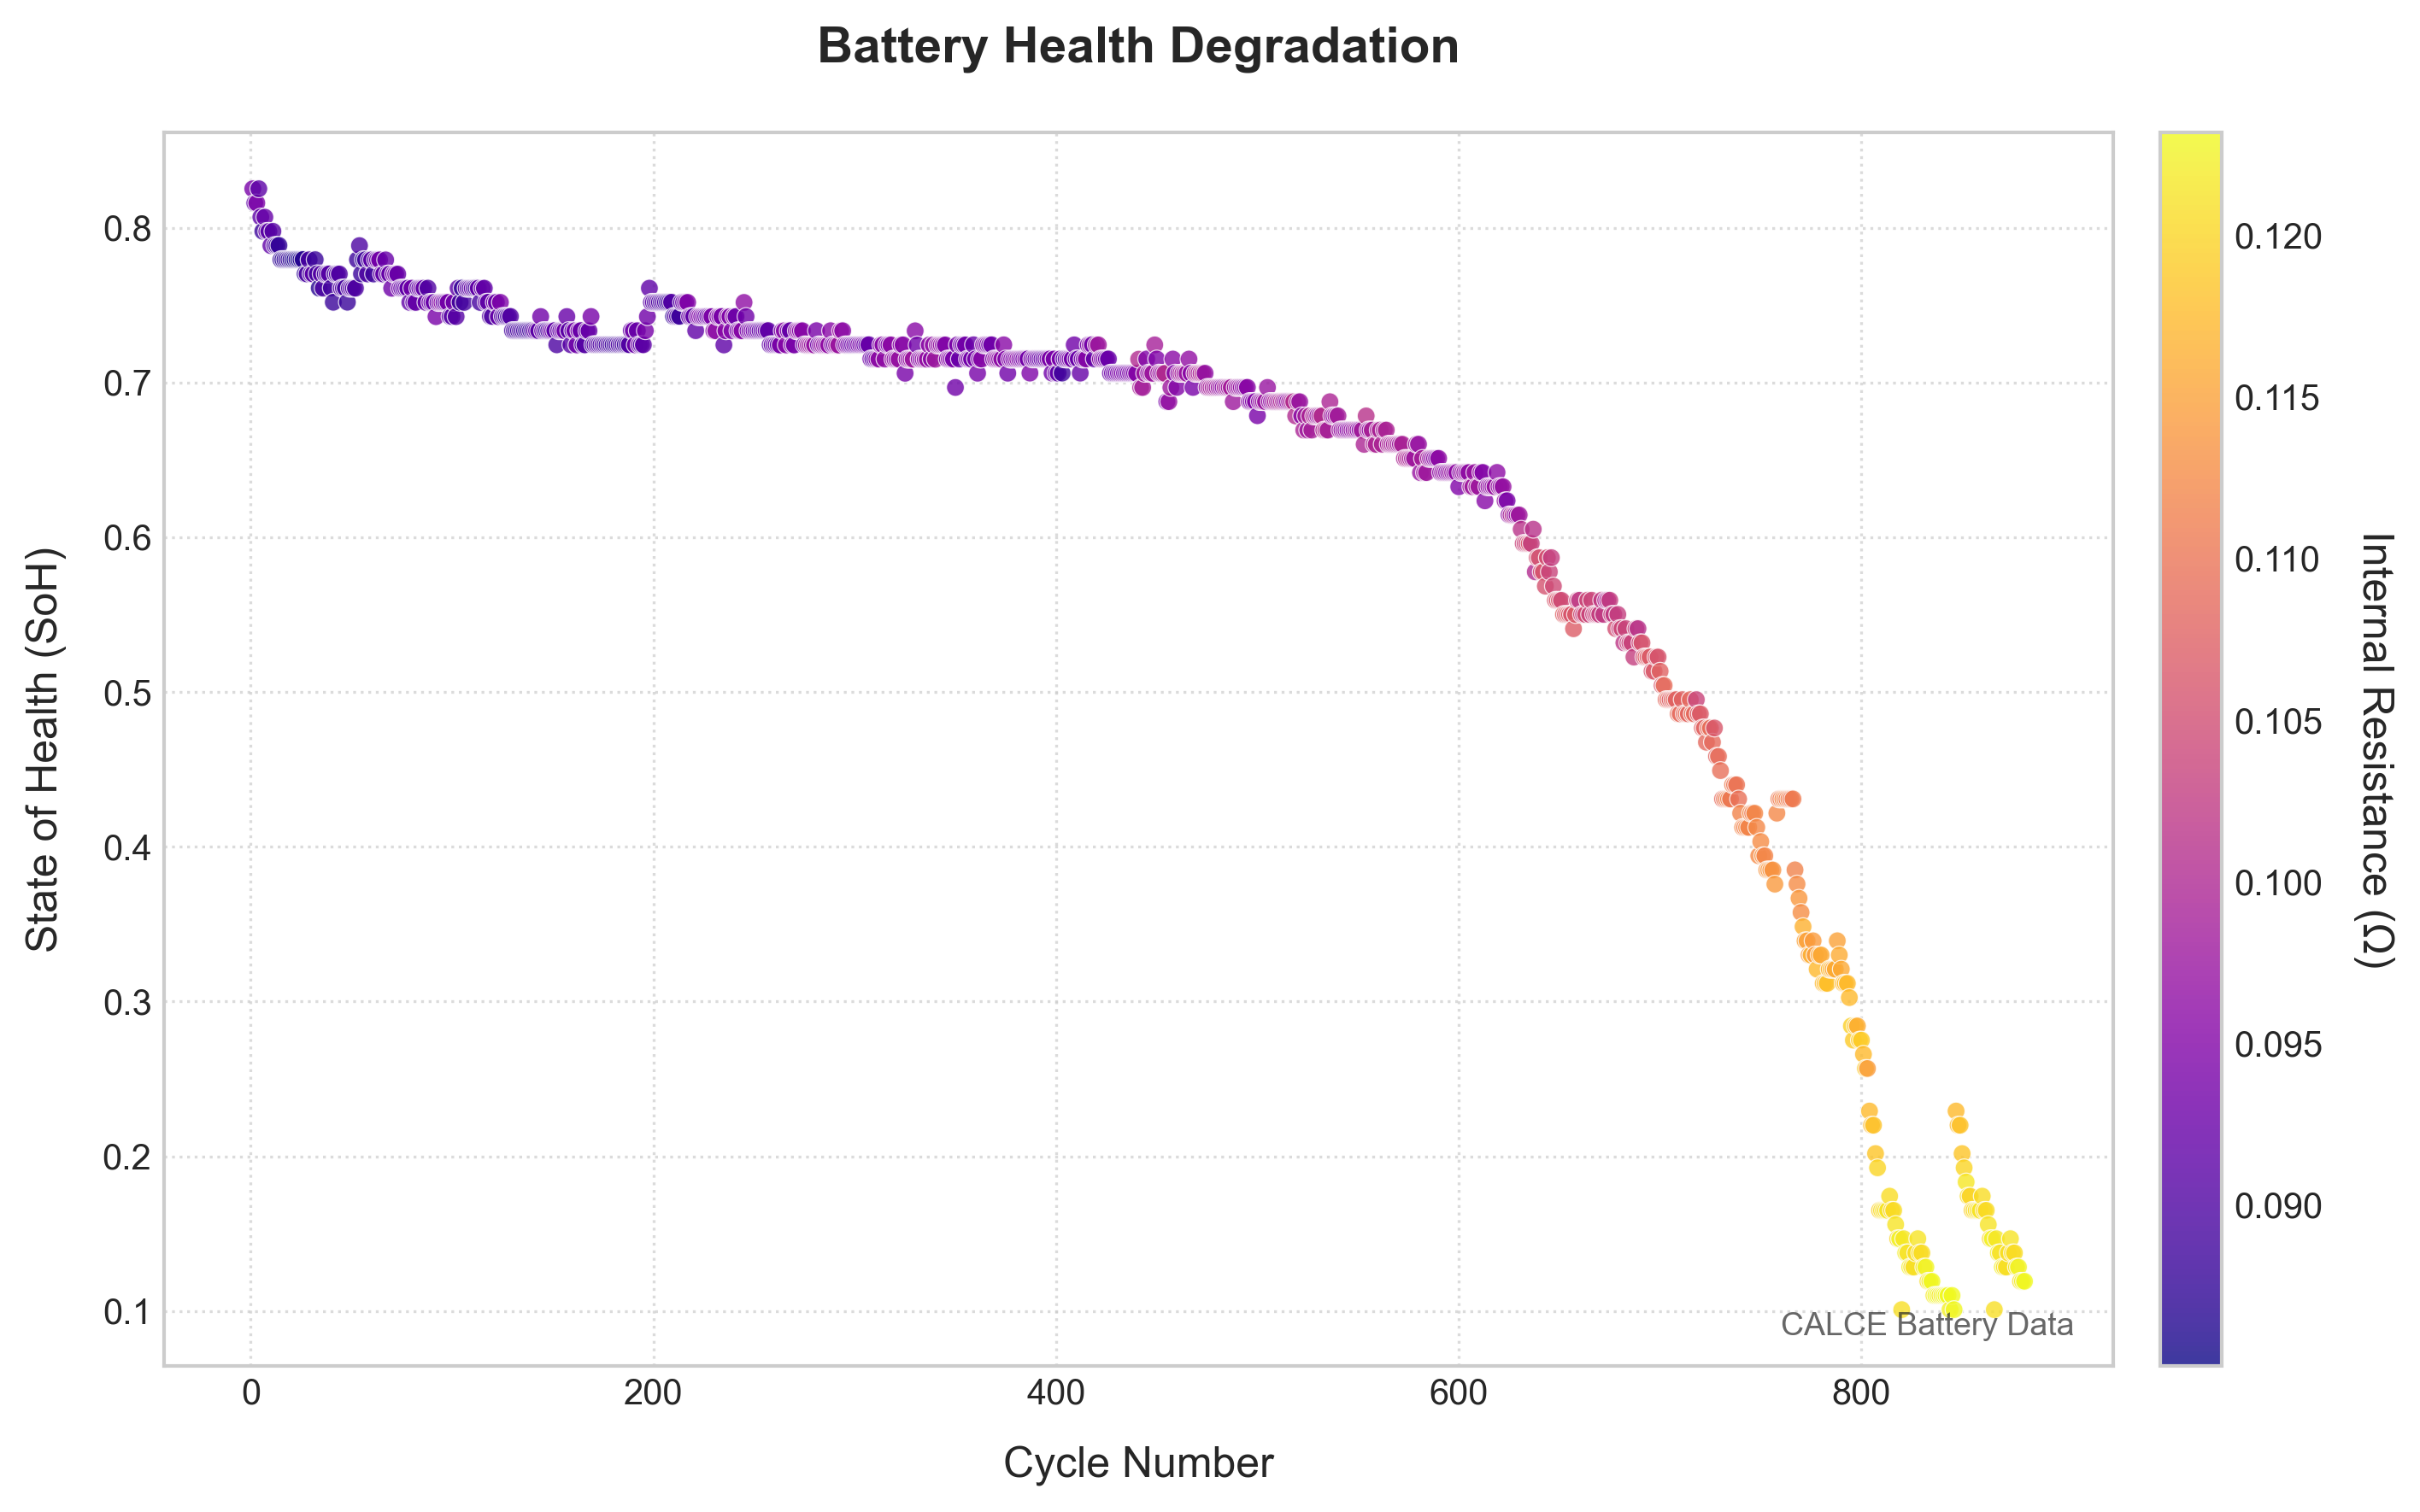

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl

# Load your battery data (replace with your actual data loading code)
# This assumes you've already created the Battery dictionary as shown in your earlier code
battery = Battery['CS2_35']  # Select which battery to plot

# Set global style
mpl.rcParams['font.family'] = 'Arial'
plt.style.use('seaborn-v0_8-whitegrid')

# Create figure
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

# Scatter plot with enhanced styling
sc = ax.scatter(
    battery['cycle'], 
    battery['SoH'], 
    c=battery['resistance'],
    s=25,
    cmap='plasma',
    edgecolor='white',
    linewidth=0.3,
    alpha=0.8
)

# Colorbar styling
cbar = plt.colorbar(sc, pad=0.02)
cbar.set_label('Internal Resistance (Ω)', 
               fontsize=12, 
               rotation=-90,
               labelpad=20)
cbar.ax.tick_params(labelsize=10)

# Axis labels
ax.set_xlabel('Cycle Number', fontsize=12, labelpad=10)
ax.set_ylabel('State of Health (SoH)', fontsize=12, labelpad=10)

# Title and grid
ax.set_title('Battery Health Degradation', 
             fontsize=14, pad=20, fontweight='bold')
ax.grid(True, linestyle=':', alpha=0.7)

# Adjust ticks
ax.tick_params(axis='both', which='major', labelsize=10)

# Add annotation
plt.text(0.98, 0.02, 'CALCE Battery Data', 
         fontsize=9, alpha=0.7,
         ha='right', va='bottom', 
         transform=ax.transAxes)

plt.tight_layout()
plt.show()

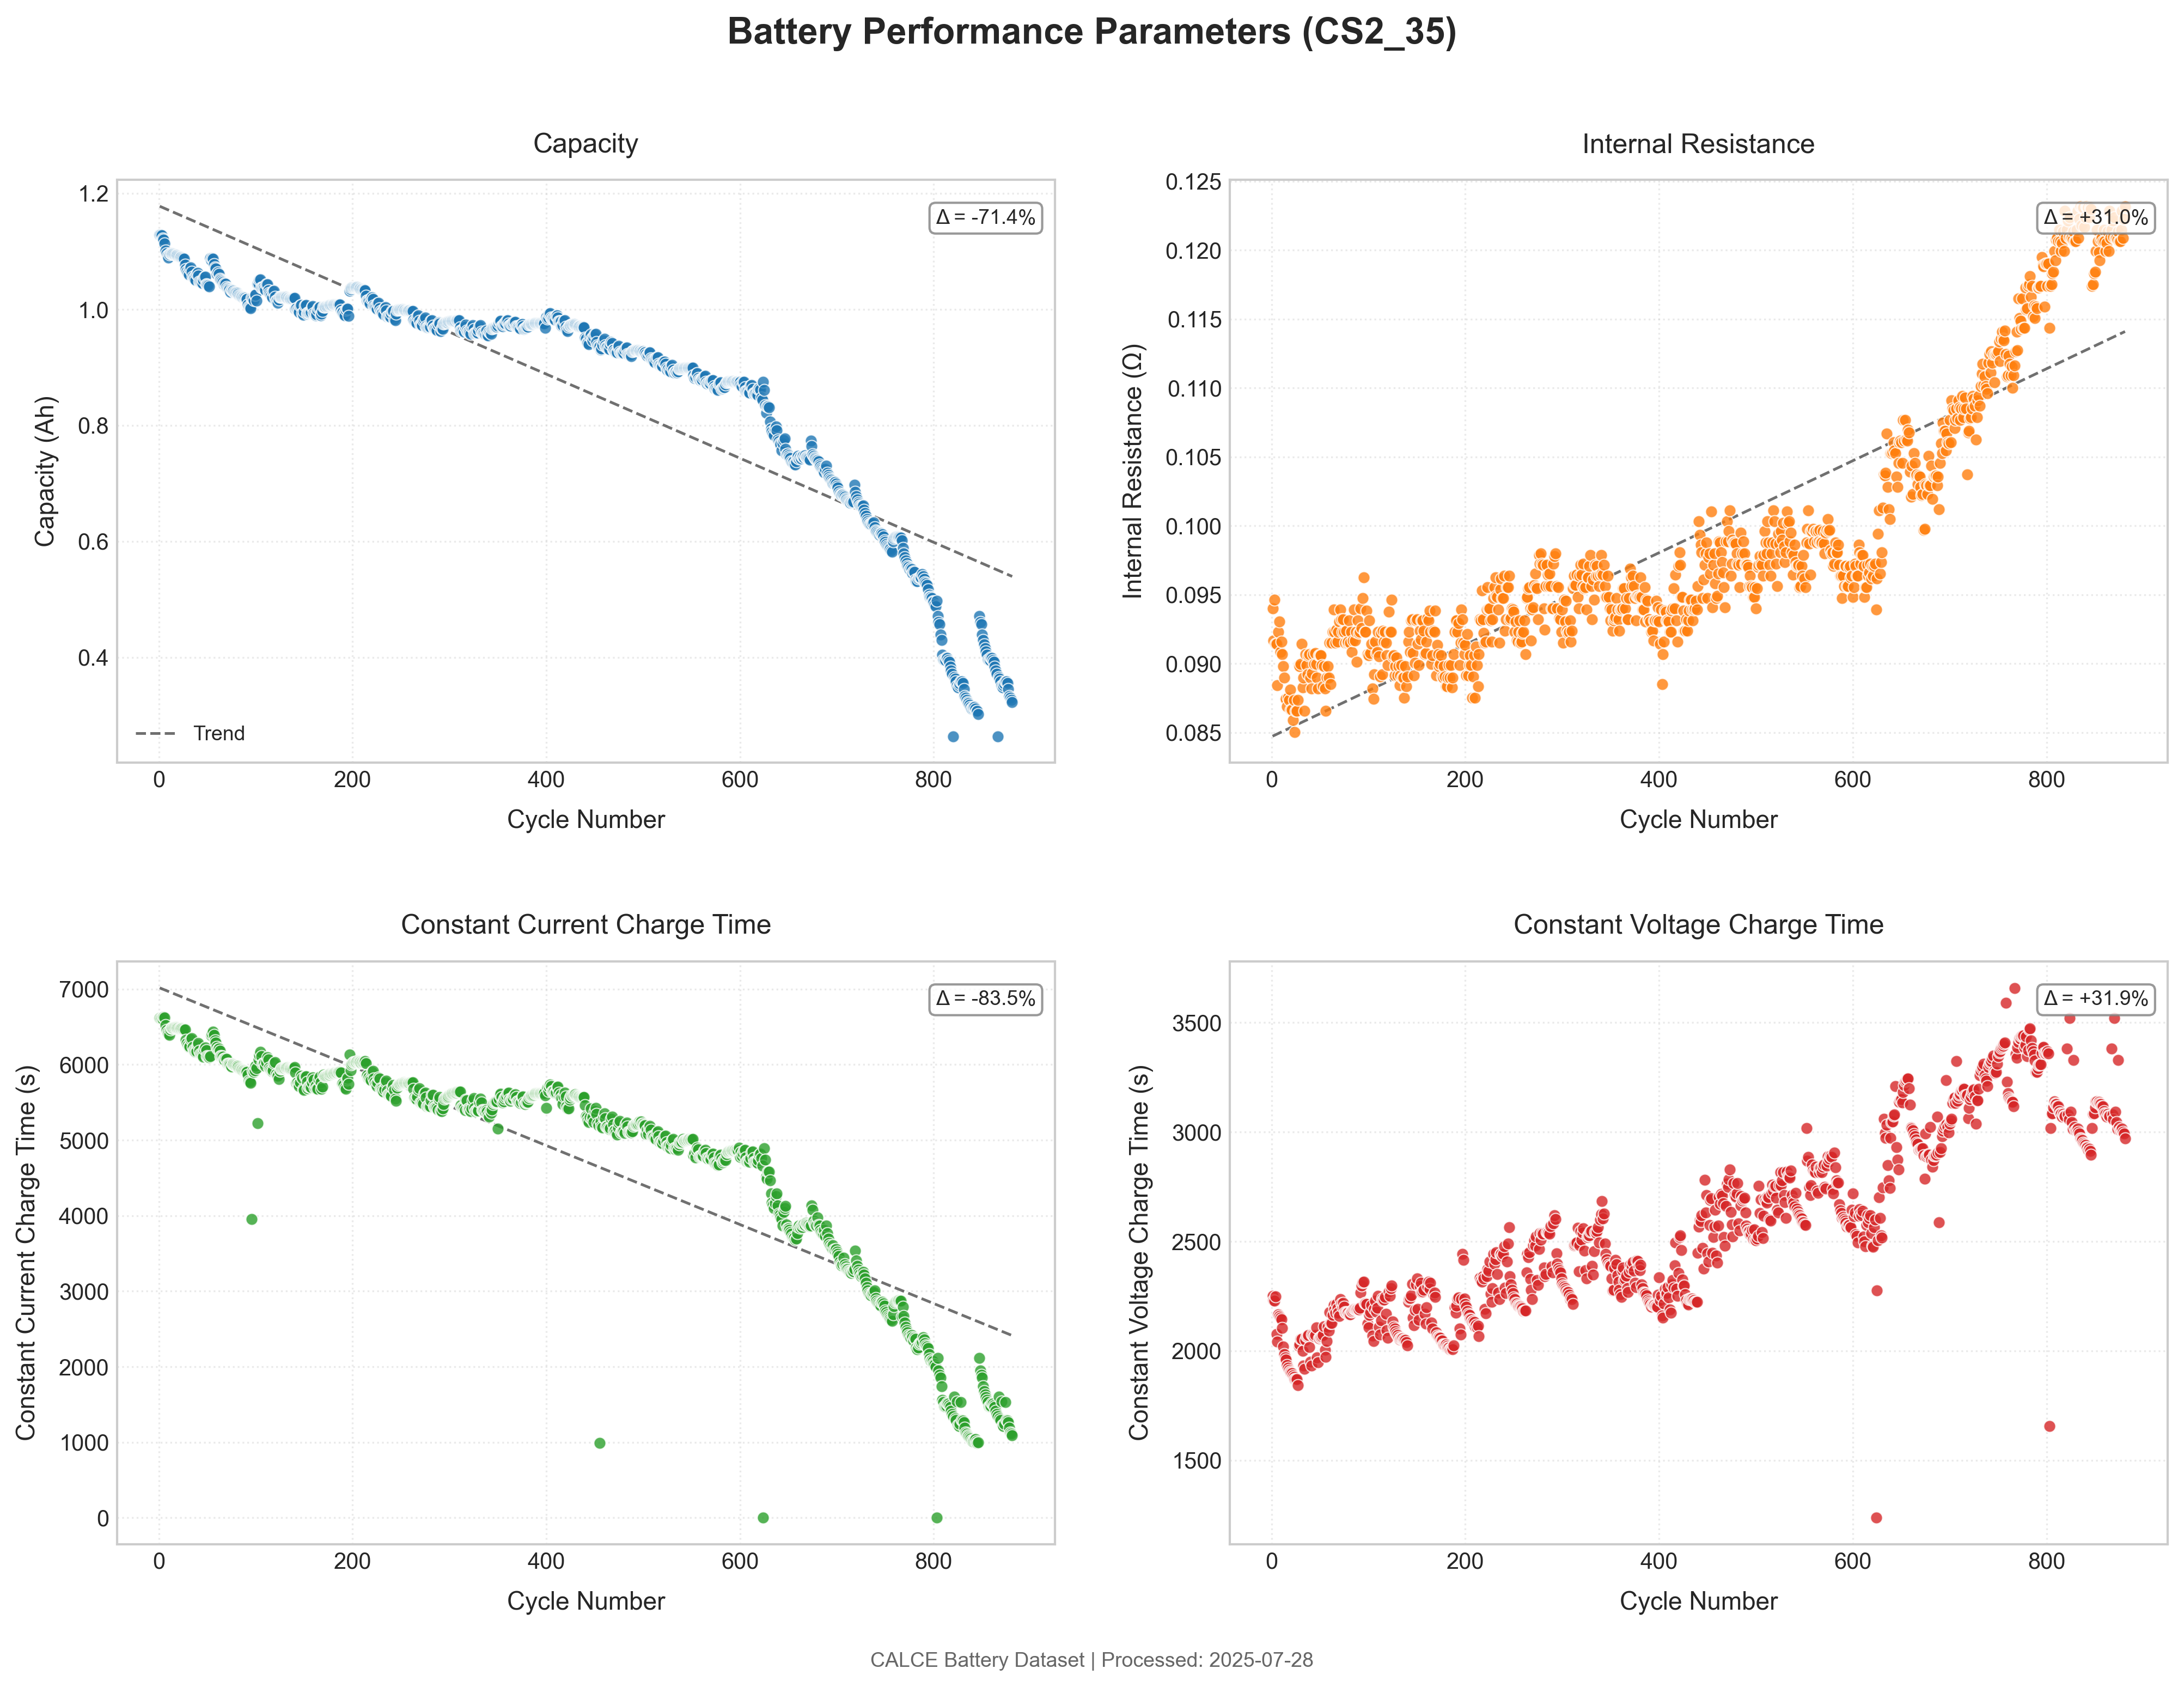

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# Set global style
mpl.rcParams['font.family'] = 'Arial'
plt.style.use('seaborn-v0_8-whitegrid')

# Create figure
fig = plt.figure(figsize=(14, 10), dpi=300)
fig.suptitle('Battery Performance Parameters (CS2_35)', 
             fontsize=16, y=1.02, fontweight='bold')

# Parameter definitions with units and styling
params = [
    {'name': 'capacity', 'label': 'Capacity (Ah)', 'color': '#1f77b4', 'ylim': None},
    {'name': 'resistance', 'label': 'Internal Resistance (Ω)', 'color': '#ff7f0e', 'ylim': None},
    {'name': 'CCCT', 'label': 'Constant Current Charge Time (s)', 'color': '#2ca02c', 'ylim': None},
    {'name': 'CVCT', 'label': 'Constant Voltage Charge Time (s)', 'color': '#d62728', 'ylim': None}
]

for i, param in enumerate(params):
    ax = fig.add_subplot(2, 2, i+1)
    
    # Enhanced scatter plot
    ax.scatter(
        battery['cycle'], 
        battery[param['name']],
        s=28,
        color=param['color'],
        edgecolor='white',
        linewidth=0.5,
        alpha=0.8,
        zorder=3
    )
    
    # Add trend line
    z = np.polyfit(battery['cycle'], battery[param['name']], 1)
    p = np.poly1d(z)
    ax.plot(battery['cycle'], p(battery['cycle']), 
            color='#333333', 
            linestyle='--',
            linewidth=1.2,
            alpha=0.7,
            zorder=2,
            label='Trend')
    
    # Labels and titles
    ax.set_xlabel('Cycle Number', fontsize=11, labelpad=8)
    ax.set_ylabel(param['label'], fontsize=11, labelpad=8)
    ax.set_title(param['label'].split(' (')[0], fontsize=12, pad=12)
    
    # Grid and style
    ax.grid(True, linestyle=':', alpha=0.4, zorder=1)
    ax.tick_params(axis='both', labelsize=10)
    
    # Set y-axis limits if specified
    if param['ylim']:
        ax.set_ylim(param['ylim'])
    
    # Add legend for trend line
    if i == 0:
        ax.legend(fontsize=9, framealpha=1)
    
    # Add annotation for first/last values
    first_val = battery[param['name']].iloc[0]
    last_val = battery[param['name']].iloc[-1]
    change_pct = (last_val - first_val)/first_val * 100
    
    ax.annotate(f"Δ = {change_pct:+.1f}%", 
               xy=(0.98, 0.95), 
               xycoords='axes fraction',
               ha='right', 
               va='top',
               fontsize=9,
               bbox=dict(boxstyle='round,pad=0.3', 
                         fc='white', 
                         ec='gray', 
                         alpha=0.8))

# Adjust layout
plt.tight_layout(pad=3.0)
plt.subplots_adjust(top=0.92)

# Add data source annotation
plt.figtext(0.5, 0.01, 'CALCE Battery Dataset | Processed: ' + pd.Timestamp.now().strftime('%Y-%m-%d'), 
            ha='center', fontsize=9, alpha=0.7)

plt.show()

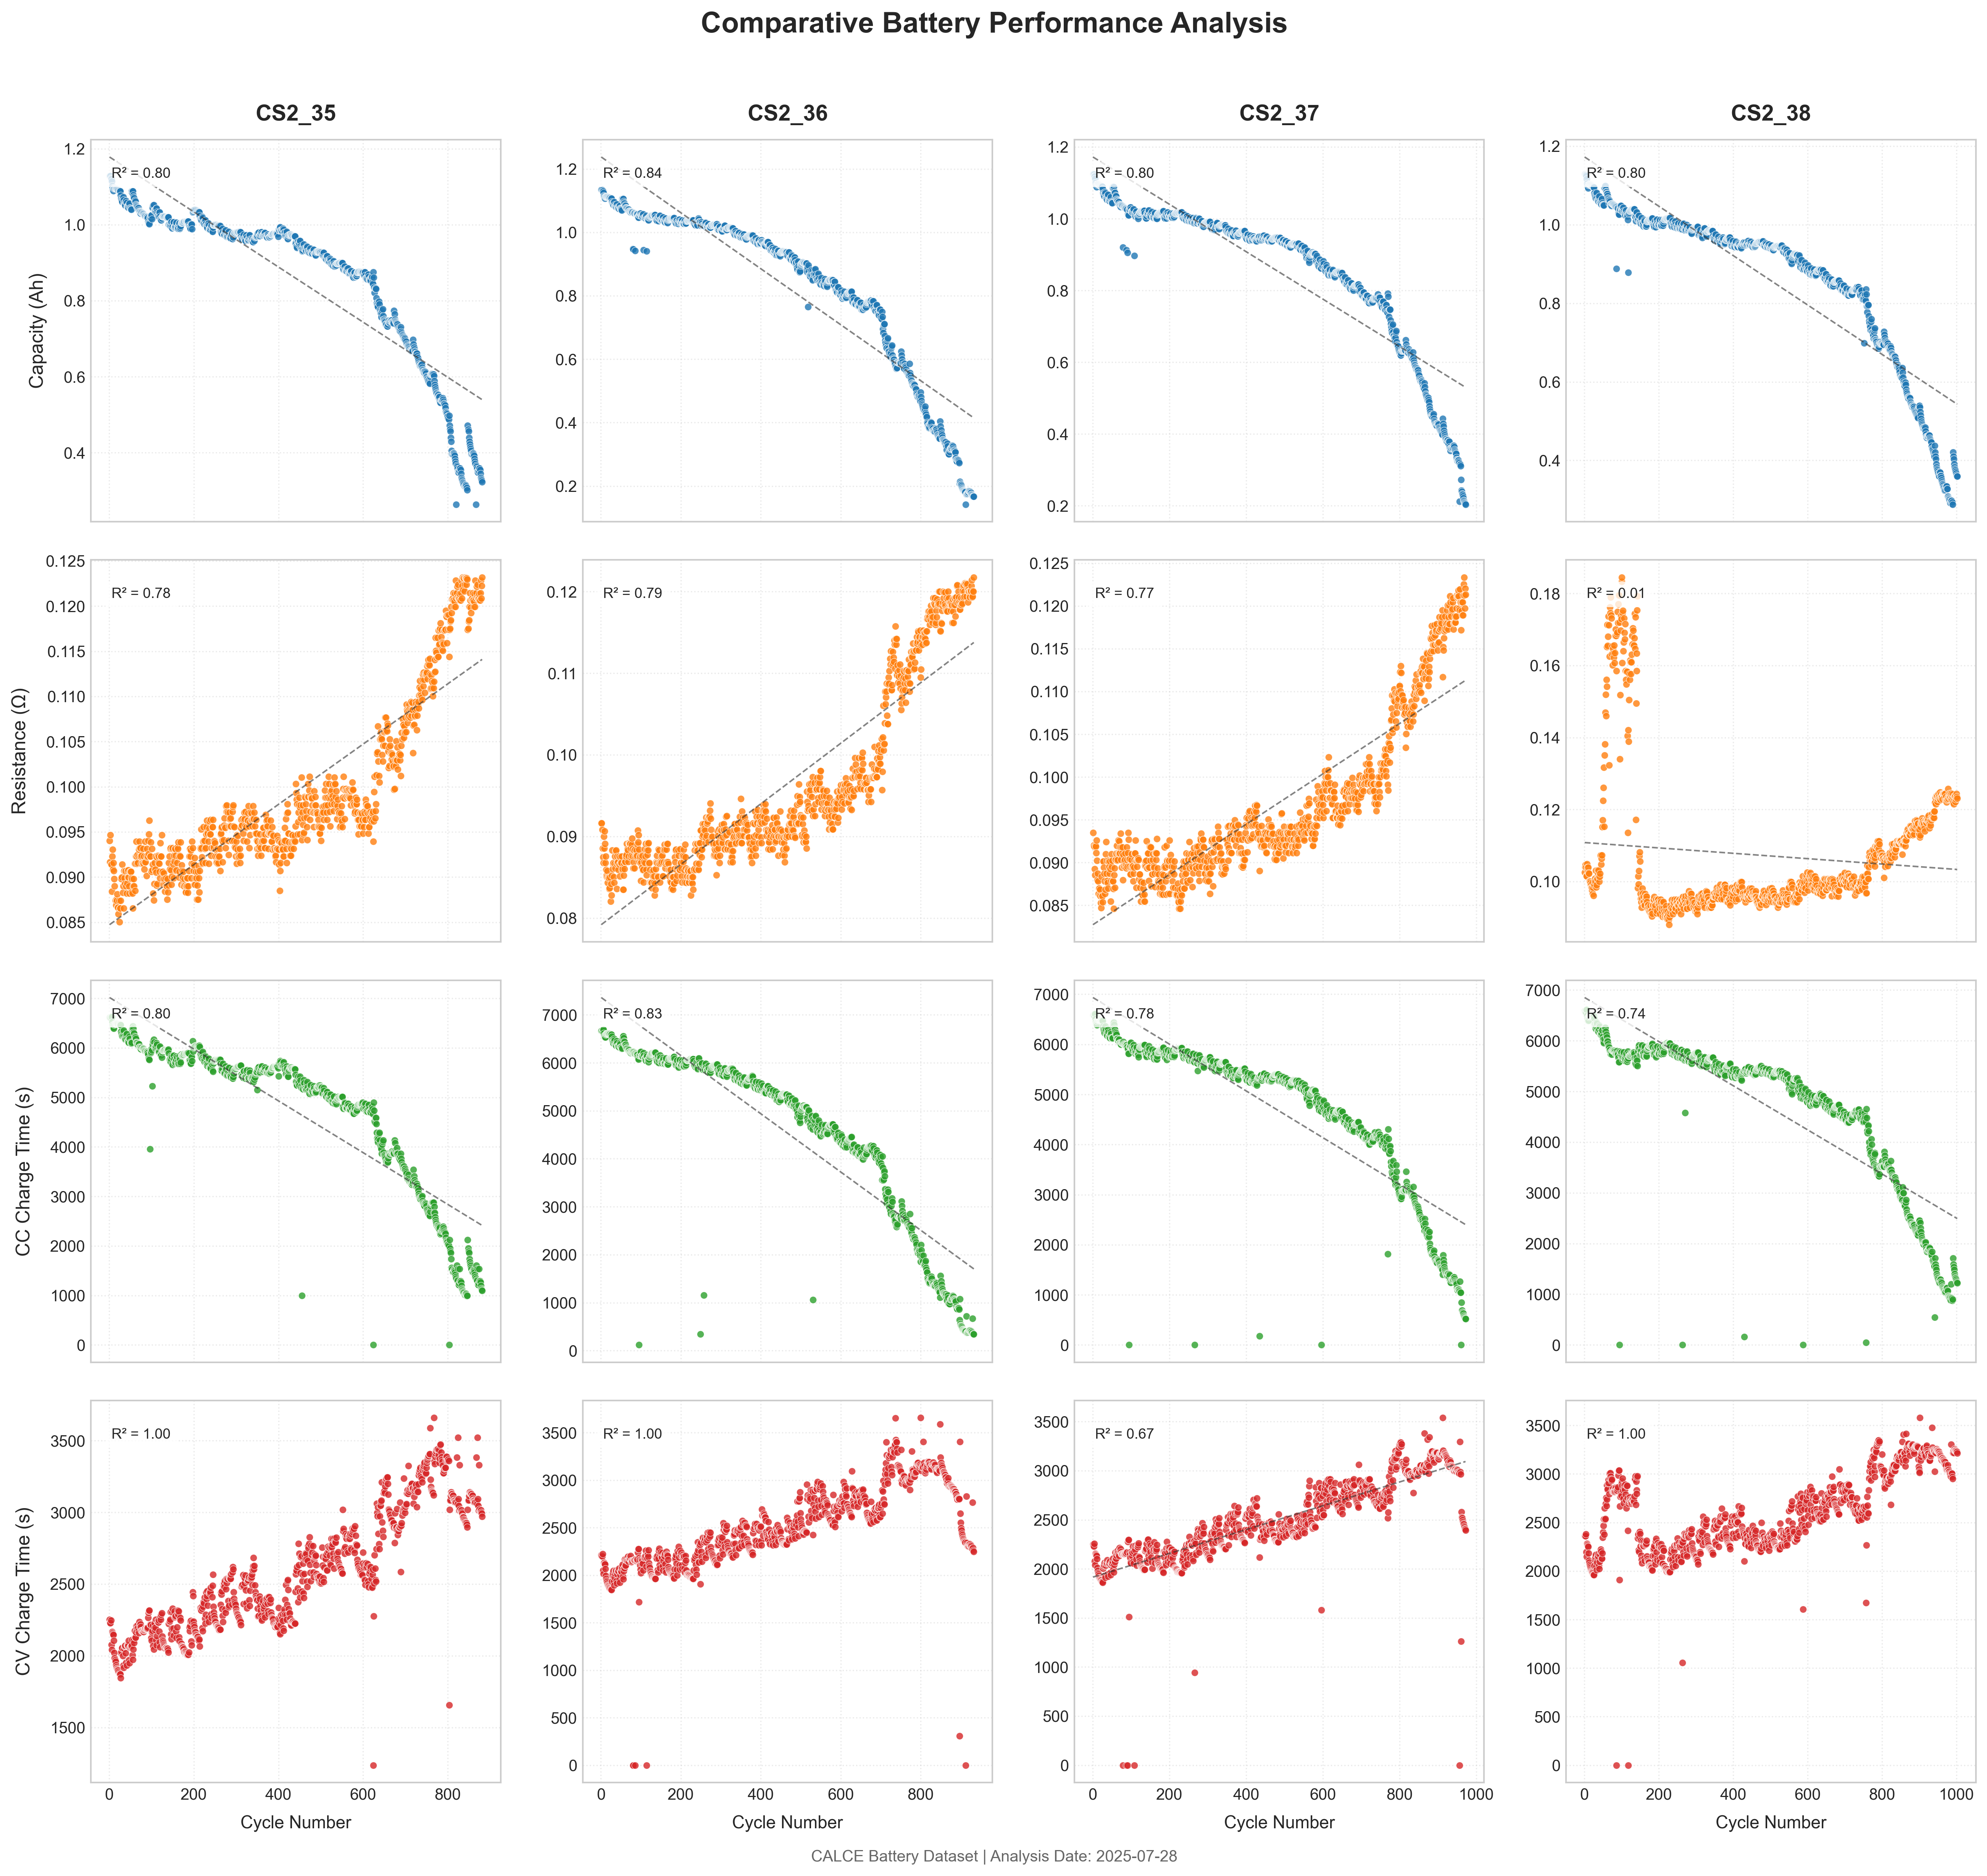

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# Set global style
mpl.rcParams['font.family'] = 'Arial'
plt.style.use('seaborn-v0_8-whitegrid')

# Create a 4x4 grid (4 batteries x 4 parameters)
fig, axs = plt.subplots(4, 4, figsize=(18, 16), dpi=300)
fig.suptitle('Comparative Battery Performance Analysis', 
             fontsize=18, y=1.02, fontweight='bold')

# Parameter definitions
params = [
    {'name': 'capacity', 'label': 'Capacity (Ah)', 'color': '#1f77b4'},
    {'name': 'resistance', 'label': 'Resistance (Ω)', 'color': '#ff7f0e'},
    {'name': 'CCCT', 'label': 'CC Charge Time (s)', 'color': '#2ca02c'},
    {'name': 'CVCT', 'label': 'CV Charge Time (s)', 'color': '#d62728'}
]

battery_names = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']

for col, battery_name in enumerate(battery_names):
    battery = Battery[battery_name]
    
    for row, param in enumerate(params):
        ax = axs[row, col]
        
        # Scatter plot with trend line
        ax.scatter(
            battery['cycle'],
            battery[param['name']],
            s=20,
            color=param['color'],
            edgecolor='white',
            linewidth=0.3,
            alpha=0.8
        )
        
        # Add trend line
        z = np.polyfit(battery['cycle'], battery[param['name']], 1)
        p = np.poly1d(z)
        ax.plot(battery['cycle'], p(battery['cycle']), 
                color='#333333', 
                linestyle='--',
                linewidth=1,
                alpha=0.6)
        
        # Column headers (battery names)
        if row == 0:
            ax.set_title(battery_name, fontsize=14, pad=12, fontweight='bold')
            
        # Row labels (only first column)
        if col == 0:
            ax.set_ylabel(param['label'], fontsize=12, labelpad=10)
            
        # X labels (only bottom row)
        if row == 3:
            ax.set_xlabel('Cycle Number', fontsize=11, labelpad=8)
        else:
            ax.set_xticklabels([])
            
        # Grid and style
        ax.grid(True, linestyle=':', alpha=0.4)
        ax.tick_params(labelsize=10)
        
        # Add R² value annotation
        y = battery[param['name']]
        yhat = p(battery['cycle'])
        ss_res = np.sum((y - yhat) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r2 = 1 - (ss_res / ss_tot)
        
        ax.text(0.05, 0.9, f'R² = {r2:.2f}', 
                transform=ax.transAxes,
                fontsize=9,
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# Adjust layout
plt.tight_layout(pad=3.0)
plt.subplots_adjust(top=0.95, hspace=0.1, wspace=0.2)

# Add footer
plt.figtext(0.5, 0.01, 
            'CALCE Battery Dataset | Analysis Date: ' + pd.Timestamp.now().strftime('%Y-%m-%d'), 
            ha='center', fontsize=10, alpha=0.7)

plt.show()